## **Run Ensemble Streamflow Prediction (ESP) Seasonal Forecasts with the GR6J model**




UKCEH West Africa Hydrological Forecasting Training Workshop 2026

Katie Facer-Childs, Ezra Kitson, Eugene Magee, Adriana Calderon, Lucy Barker

(c) UKCEH 2026

This notebook runs an ESP seasonal forecast using the GR6J rainfall–runoff model in R. It uses observed meteorological and streamflow data to simulate historical conditions and then builds an ESP ensemble representing plausible future scenarios.


**Install packages - this may take a little time**

In [ ]:
install.packages(c(
  "airGR",
  "dplyr",
  "ggplot2",
  "lubridate",
  "tidyr"
))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Load packages into the environment**

In [ ]:
suppressMessages({
  library(airGR)
  library(dplyr)
  library(ggplot2)
  library(lubridate)
  library(tidyr)
})

**Define useful functions: makeDate and RemoveLeapDay**

In [ ]:
MakeDate <- function (day, month, year) {

  dateObject <- as.Date(paste(year, "-", month, "-", day, sep=""))
  return (dateObject)

}

RemoveLeapDay <- function (dateseries) {

  # Note: This function has been tested to work with date strings with/without
  #       a leap day present (i.e., 29th February)

  # Make sure date object
  dateseries <- as.Date(dateseries)

  # Find 29th Feb, if any
  leapDays <- which(format(dateseries, '%d') == "29" & format(dateseries, '%m') == "02")

  # If no leap days, retern series as input
  if (length(leapDays) == 0){

    return (dateseries)

  } else {

    # Remove all instances of 29th of Feb when it appears anywhere in dateseries
    dateeriesMinusLeap <- dateseries[-leapDays]

    # Return dateseries without 29th Feb
    return (dateeriesMinusLeap)

  }

}

dateFormat <- '%Y-%m-%d'

**Gather Data**

We will run ESP for two catchments:

39020 - Coln at Bilbury

81002 - Cree at Newton Stewart

This notebook runs for 81002.

In [ ]:
# edit the # here to change the catchment you are working on
#stn_id <- "39020"
stn_id <- "81002"

**Define the station and its catchment area - load in BasinObs file and model parameters defined during notebook 1.RunningGR6J**


In [ ]:
if(stn_id == "39020"){

  BasinInfoAll<-c(39020,106.7) # Lambourn in files

  # Load BasinObs from GitHub
  BasinObs <- read.csv(
  "https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/BasinObs_39020.csv",
  stringsAsFactors = FALSE
)
  # Clean the data: remove rows with errors
  BasinObs <- BasinObs[grepl("^\\d{4}-\\d{2}-\\d{2}$", BasinObs$DATE), ]

  BasinObs$DATE <- as.POSIXct(BasinObs$DATE, format = dateFormat)

  # Model parameters - Coln
  Param <- c(220.935,-0.264,573.011,6.474,0.207,13.281)

}
if(stn_id == "81002"){

  BasinInfoAll<-c(81002,368) # Cree in files

  # Read BasinObs
  # load from GitHub
  BasinObs <- read.csv(
    "https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/BasinObs_81002.csv"
    )
  # Clean the data: remove rows with errors
  BasinObs <- BasinObs[grepl("^\\d{4}-\\d{2}-\\d{2}$", BasinObs$DATE), ]
  BasinObs$DATE <- as.POSIXct(BasinObs$DATE, format = dateFormat) ##CHANGE dateFormat for new station

  # Model parameters - Cree
  Param <- c(33.801,-0.257,8.725,1.385,0.276,7.796) #autoCal_RunModel_GR6J_P3_KGE2sqrt
  #Param <- c(33.801,-1.043,31.287,1.361,0.556,0.878) #RunGR6J model parameter

}

**Take a look at the structure of the file and the period it covers**

In [ ]:
head(BasinObs)
tail(BasinObs)

,DATE,PRECIP,PET,FLOW_cumecs
,<dttm>,<dbl>,<dbl>,<dbl>
1,1960-01-01,0.00000000,0.2343561,NA
2,1960-01-02,0.02996139,0.1969011,NA
3,1960-01-03,6.26326778,0.2255305,NA
4,1960-01-04,9.06946376,0.2379835,NA
5,1960-01-05,0.97165633,0.2140101,NA
6,1960-01-06,0.12967176,0.2129633,NA


,DATE,PRECIP,PET,FLOW_cumecs
,<dttm>,<dbl>,<dbl>,<dbl>
23878,2023-12-26,28.775154,0.1981631,24.23
23879,2023-12-27,26.529828,0.2152607,150.60
23880,2023-12-28,7.029323,0.2230708,48.57
23881,2023-12-29,9.177904,0.2165183,41.08
23882,2023-12-30,23.140543,0.1886552,53.72
23883,2023-12-31,16.642511,0.2085451,61.56


In [ ]:
# set data
DatesR    <- as.POSIXlt(BasinObs$DATE) # Get date in as.POSIXlt format
Precip    <- BasinObs$PRECIP
PotEvap   <- BasinObs$PET
CatchArea <- BasinInfoAll[2]

# Run GR6J for the observation period
To run the model with observed precipitation and PET up to the point at which you want to run the forecast. This is also called "running the baseline"

In [ ]:
InputsModel <- CreateInputsModel(FUN_MOD = RunModel_GR6J, DatesR = DatesR,
                                 Precip = Precip, PotEvap = PotEvap)
Ind_Run <- seq(1:length(DatesR))
RunOptions <- suppressWarnings(CreateRunOptions(FUN_MOD = RunModel_GR6J,
                                                InputsModel = InputsModel, IndPeriod_Run = Ind_Run,
                                                IniStates = NULL, IniResLevels = NULL,
                                                IndPeriod_WarmUp = NULL))
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions  = RunOptions,
                              Param       = Param)
obsSim<-as.data.frame(matrix(ncol=2,nrow=length(BasinObs$DATE),NA))
obsSim[,1]<-BasinObs$DATE
obsSim[,2]<-OutputsModel$Qsim
head(obsSim)

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used



,V1,V2
,<dttm>,<dbl>
1,1960-01-01,5.436638
2,1960-01-02,3.187504
3,1960-01-03,2.310879
4,1960-01-04,2.053235
5,1960-01-05,1.952264
6,1960-01-06,1.519528


Do some tidying

In [ ]:
# Remove first 4 years as warm-up as change DATE to as.Date
colnames(obsSim) <- c("DATE", "obsSim")
obsSim$DATE<-as.Date(obsSim$DATE)
obsSim <- obsSim[which(obsSim$DATE > MakeDate(31,12,1963)), ]

# convert to cumecs
obsSim$obsSim <- (obsSim$obsSim * CatchArea) / 86.4

# merge with obs
obsSim$obs <- BasinObs$FLOW_cumecs[which(BasinObs$DATE==as.POSIXct(obsSim$DATE[1])):
                                     length(BasinObs$DATE)]

head(obsSim)

,DATE,obsSim,obs
,<date>,<dbl>,<dbl>
1462,1964-01-01,13.597443,14.10
1463,1964-01-02,7.344855,10.25
1464,1964-01-03,12.761697,18.35
1465,1964-01-04,22.545113,42.76
1466,1964-01-05,11.324156,13.85
1467,1964-01-06,8.022978,10.59


**Make a plot of the baseline run**

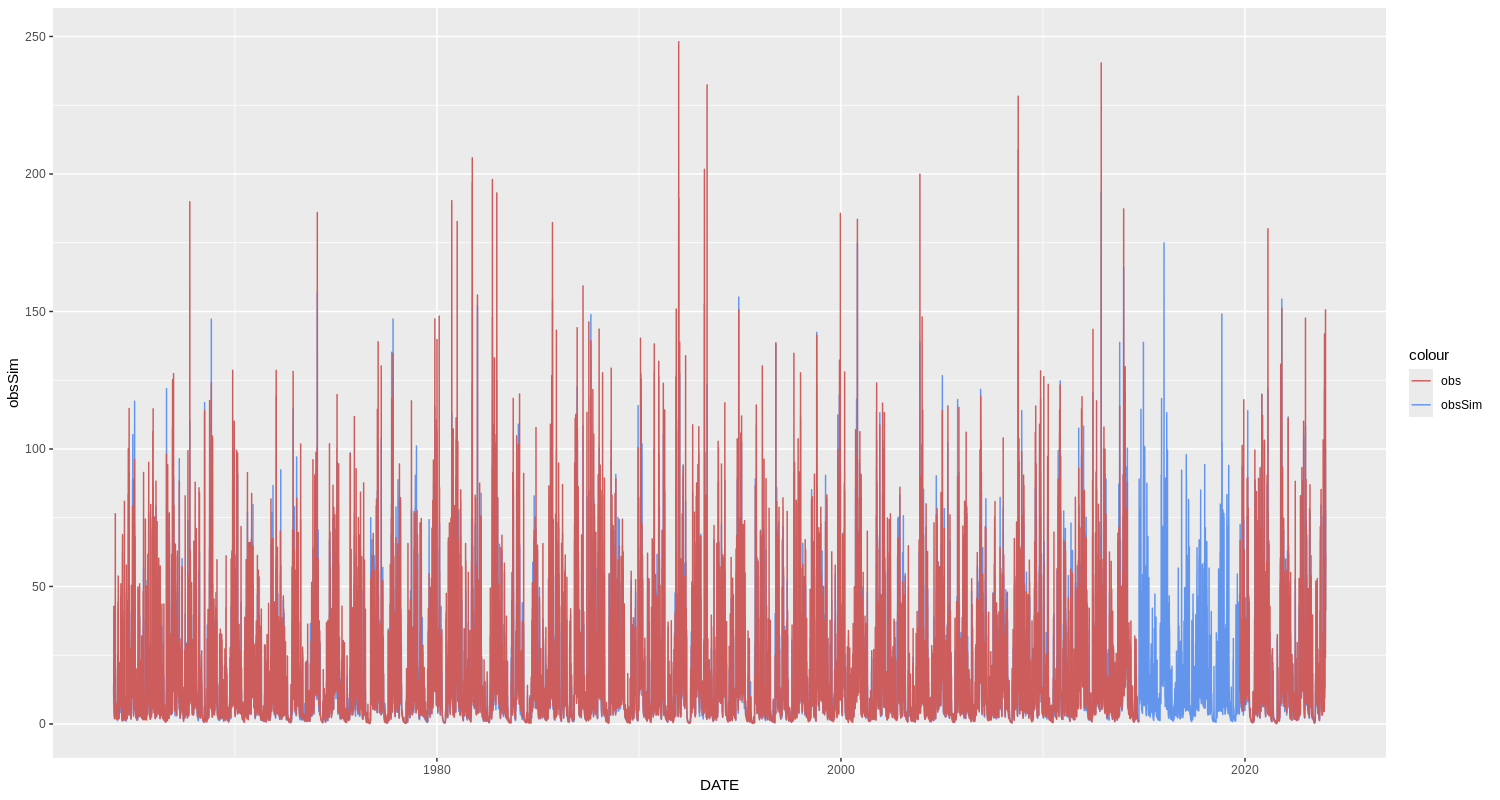

In [ ]:
#first set the dimensions of the plots in this notebook
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100)
#then plot
ggplot(obsSim)+
  geom_line(aes(x=DATE,y=obsSim,color="obsSim"))+
  geom_line(aes(x=DATE,y=obs, color="obs"))+
  scale_colour_manual(values=c("obs"="indianred","obsSim"="cornflowerblue"))

knitr::opts_chunk$set(fig.width=8) # this just makes all the plots we will do a bit wider

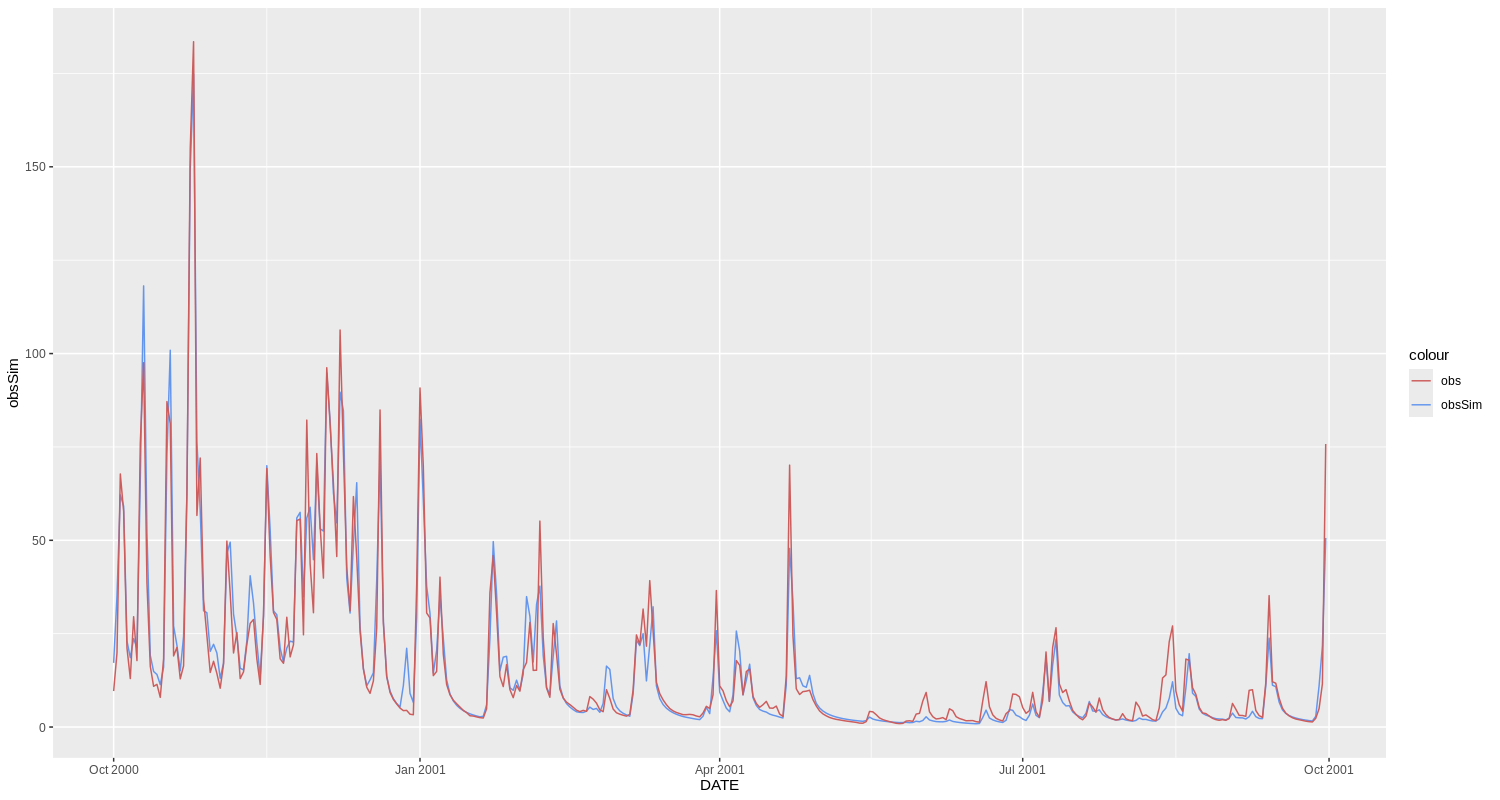

In [ ]:
#zoom in a bit
ggplot(obsSim[which(obsSim$DATE=="2000-10-01"):which(obsSim$DATE=="2001-09-30"),])+
  geom_line(aes(x=DATE,y=obsSim,color="obsSim"))+
  geom_line(aes(x=DATE,y=obs, color="obs"))+
  scale_colour_manual(values=c("obs"="indianred","obsSim"="cornflowerblue"))

Go back and change the station to 81002 (swap the # next to stn_id in the above code snippet, then rerun the code sections), compare this with a partner who has 39019 plotted up. Can you see the difference in the hydrographs? What does this tell you about the catchments?


# Create Input Data for ESP

Preaparing a clean dataset for ESP. Remove the first few months to mirror start month of forecast.

In [ ]:
BasinObs$DATE <- as.Date(BasinObs$DATE)
BasinObs<-BasinObs[which(BasinObs$DATE >= MakeDate(01,01,1960)),]
head(BasinObs)

,DATE,PRECIP,PET,FLOW_cumecs
,<date>,<dbl>,<dbl>,<dbl>
1,1960-01-01,0.00000000,0.2343561,NA
2,1960-01-02,0.02996139,0.1969011,NA
3,1960-01-03,6.26326778,0.2255305,NA
4,1960-01-04,9.06946376,0.2379835,NA
5,1960-01-05,0.97165633,0.2140101,NA
6,1960-01-06,0.12967176,0.2129633,NA


**Check NA values...**

How long is the dataset (in days), and how many NA values are there?
Which is the first row with data? (that's NOT NA)

In [ ]:
length(BasinObs$FLOW_cumecs)
length(which(is.na(BasinObs$FLOW_cumecs)))
BasinObs[which(!is.na(BasinObs$FLOW_cumecs))[1],]

[1] 23376

[1] 3195

,DATE,PRECIP,PET,FLOW_cumecs
,<date>,<dbl>,<dbl>,<dbl>
1370,1963-10-01,6.093764,0.9923856,31.43


OK, the data starts in Oct 1963...

Remove leap years from BasinObs

In [ ]:
NoLeap <- RemoveLeapDay(BasinObs$DATE)
BasinObsNoLeap <- as.data.frame(NoLeap)
colnames(BasinObsNoLeap)<-c("DATE")
BasinObsNoLeap <- left_join(BasinObsNoLeap, BasinObs, by = "DATE")

**Create ESP input matrix for precipitation**

In [ ]:
# ============================================================================
# Create ESP input matrix for precipitation
# Structure: Each column = one historical year (ensemble member)
#            Rows = daily values that can be sampled for forecasting
# ============================================================================

#create input table for precip
PrecipESPin<-as.data.frame(matrix(NA,nrow=length(BasinObsNoLeap$DATE),ncol=(2024-1960)+1))

#name columns: DATE, + ensemble members - ENS1960, ENS1961, ...,
colnames(PrecipESPin)<-c("DATE",paste0("ENS",seq(1960,2023)))

#Fill with hisorical data
PrecipESPin$DATE<-RemoveLeapDay(seq(MakeDate(01,01,1960),MakeDate(31,12,2023),by="day"))
PrecipESPin[1:length(BasinObsNoLeap$DATE),2:ncol(PrecipESPin)]<-BasinObsNoLeap$PRECIP

#Reshape into 365-day year format abd create ESP structure
precipmatrix<-as.data.frame(matrix(BasinObsNoLeap$PRECIP,nrow=365,byrow=F))
colnames(precipmatrix)<-paste0("ENS",seq(1960,2023))

#Set 2024 as forecast year
precipmatrix$DATE<-RemoveLeapDay(seq(MakeDate(01,01,2024),MakeDate(31,12,2024),by="day"))

#Combine hisotrical period (1960-2023) and forecast year(2024)
PrecipESPin<-rbind(PrecipESPin,precipmatrix)
head(PrecipESPin)

,DATE,ENS1960,ENS1961,ENS1962,ENS1963,ENS1964,ENS1965,ENS1966,ENS1967,ENS1968,⋯,ENS2014,ENS2015,ENS2016,ENS2017,ENS2018,ENS2019,ENS2020,ENS2021,ENS2022,ENS2023
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1960-01-01,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,1960-01-02,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,⋯,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139,0.02996139
3,1960-01-03,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,⋯,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778,6.26326778
4,1960-01-04,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,⋯,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376,9.06946376
5,1960-01-05,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,⋯,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633,0.97165633
6,1960-01-06,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,⋯,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176,0.12967176


**Make input matrix for PET**

In [ ]:
PetESPin<-as.data.frame(matrix(NA,nrow=length(BasinObsNoLeap$DATE),ncol=(2024-1960)+1))
colnames(PetESPin)<-c("DATE",paste0("ENS",seq(1960,2023)))
PetESPin$DATE<-RemoveLeapDay(seq(MakeDate(01,01,1960),MakeDate(31,12,2023),by="day"))
PetESPin[1:length(BasinObsNoLeap$DATE),2:ncol(PetESPin)]<-BasinObsNoLeap$PET
petmatrix<-as.data.frame(matrix(BasinObsNoLeap$PET,nrow=365,byrow=F))
colnames(petmatrix)<-paste0("ENS",seq(1960,2023))
petmatrix$DATE<-RemoveLeapDay(seq(MakeDate(01,01,2024),MakeDate(31,12,2024),by="day"))
PetESPin<-rbind(PetESPin,petmatrix)
head(PetESPin)

,DATE,ENS1960,ENS1961,ENS1962,ENS1963,ENS1964,ENS1965,ENS1966,ENS1967,ENS1968,⋯,ENS2014,ENS2015,ENS2016,ENS2017,ENS2018,ENS2019,ENS2020,ENS2021,ENS2022,ENS2023
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1960-01-01,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,⋯,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561,0.2343561
2,1960-01-02,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,⋯,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011,0.1969011
3,1960-01-03,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,⋯,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305,0.2255305
4,1960-01-04,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,⋯,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835,0.2379835
5,1960-01-05,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,⋯,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101,0.2140101
6,1960-01-06,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,⋯,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633,0.2129633


**Make an empty output matrix to store the ESP runs**

In [ ]:
ESPforecasts<-as.data.frame(matrix(NA,nrow=length(BasinObsNoLeap$DATE)+365,ncol=(2024-1960)+1))
colnames(ESPforecasts)<-c("DATE",paste0("ENS",seq(1960,2023)))
ESPforecasts$DATE<-RemoveLeapDay(seq(MakeDate(01,01,1960),MakeDate(31,12,2024),by="day"))
head(ESPforecasts)
tail(ESPforecasts)


,DATE,ENS1960,ENS1961,ENS1962,ENS1963,ENS1964,ENS1965,ENS1966,ENS1967,ENS1968,⋯,ENS2014,ENS2015,ENS2016,ENS2017,ENS2018,ENS2019,ENS2020,ENS2021,ENS2022,ENS2023
,<date>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,1960-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1960-01-02,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1960-01-03,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1960-01-04,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1960-01-05,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1960-01-06,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,DATE,ENS1960,ENS1961,ENS1962,ENS1963,ENS1964,ENS1965,ENS1966,ENS1967,ENS1968,⋯,ENS2014,ENS2015,ENS2016,ENS2017,ENS2018,ENS2019,ENS2020,ENS2021,ENS2022,ENS2023
,<date>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
23720,2024-12-26,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
23721,2024-12-27,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
23722,2024-12-28,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
23723,2024-12-29,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
23724,2024-12-30,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
23725,2024-12-31,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## RUN ESP!



In [ ]:
## RUN ESP
for (i in 2:65){ # Changed loop end from 61 to 65 to include all ensemble members up to ENS2023
  # Note that we will get the following warning message here, but it is okay - we don't neeed to worry about it!
  # model warm up period not defined: default configuration used
  # no data were found for model warm up! No warm up period is used
  DatesR    <- as.POSIXlt(ESPforecasts$DATE) # Get date in as.POSIXlt format
  Precip    <- PrecipESPin[,i]
  PotEvap   <- PetESPin[,i]
  CatchArea <- BasinInfoAll[2]

  ## RUN GR6J FOR OBS PERIOD
  InputsModel <- CreateInputsModel(FUN_MOD = RunModel_GR6J, DatesR = DatesR,
                                   Precip = Precip, PotEvap = PotEvap)
  Ind_Run <- seq(1:length(DatesR))

  RunOptions <- suppressWarnings(CreateRunOptions(FUN_MOD = RunModel_GR6J,
                                                  InputsModel = InputsModel, IndPeriod_Run = Ind_Run,
                                                  IniStates = NULL, IniResLevels = NULL,
                                                  IndPeriod_WarmUp = NULL))
  OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                                RunOptions  = RunOptions,
                                Param       = Param)
  ESPforecasts[,i]<-OutputsModel$Qsim
}

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up 

**Convert runoff (mm/day) to flow (M3/s)**

In [ ]:
ESPforecasts_m3s <- ESPforecasts
ESPforecasts_m3s[,2:65] <- (ESPforecasts[2:65] * CatchArea) / 86.4

**Combine ESP forecast and obs/obsSim data into one dataframe for the plotting process**


In [ ]:
ESPplotData <- merge(ESPforecasts_m3s, obsSim, by = "DATE", all = T)
# reorder columns correctly ready for the plotting code
ESPplotData <- ESPplotData[,c("DATE","obs","obsSim",paste0("ENS",1961:2020))]

save(ESPplotData, file = paste0("ESP_PlotInput_", stn_id, ".RData"))

In [ ]:
ESPplotData

DATE,obs,obsSim,ENS1961,ENS1962,ENS1963,ENS1964,ENS1965,ENS1966,ENS1967,⋯,ENS2011,ENS2012,ENS2013,ENS2014,ENS2015,ENS2016,ENS2017,ENS2018,ENS2019,ENS2020
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1960-01-01,NA,NA,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,⋯,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052,23.156052
1960-01-02,NA,NA,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,⋯,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404,13.576404
1960-01-03,NA,NA,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,⋯,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632,9.842632
1960-01-04,NA,NA,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,⋯,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262,8.745262
1960-01-05,NA,NA,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,⋯,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199,8.315199
1960-01-06,NA,NA,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,⋯,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062,6.472062
1960-01-07,NA,NA,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,⋯,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236,5.438236
1960-01-08,NA,NA,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,⋯,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368,4.682368
1960-01-09,NA,NA,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,⋯,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356,4.106356


In [ ]:
# Check last ENS columns exist
tail(names(ESPforecasts_m3s))

# Check for any ENS columns that are still 100% NA
ens_na <- colSums(is.na(ESPforecasts_m3s[, 2:65]))
ens_na[ens_na == nrow(ESPforecasts_m3s)]


[1] "ENS2018" "ENS2019" "ENS2020" "ENS2021" "ENS2022" "ENS2023"

named numeric(0)

**Make a simple plot!**

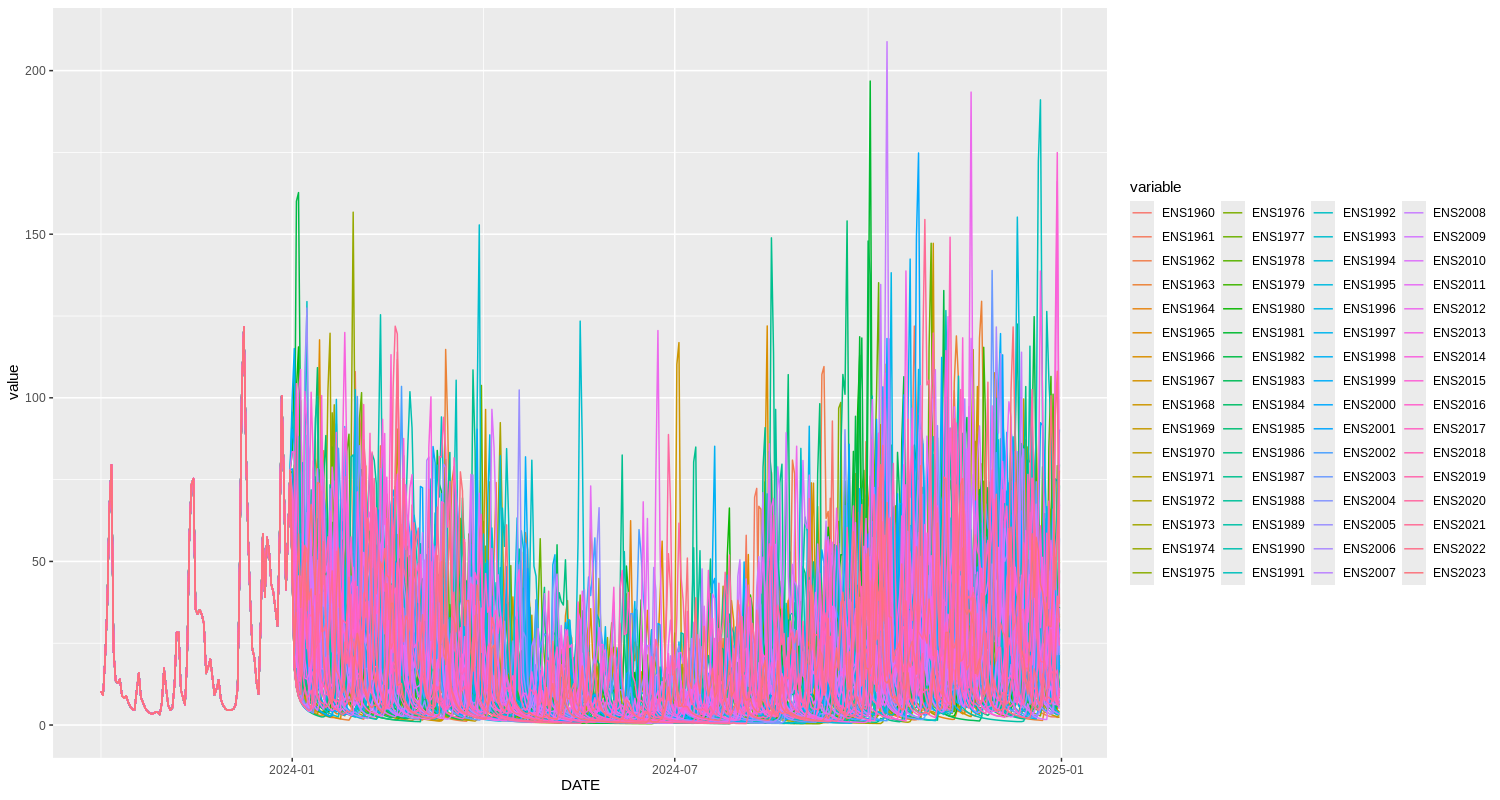

In [ ]:
# we can make a simple plot of the ESP forecast here
ESPsub <- ESPforecasts_m3s %>%
  filter(DATE > MakeDate(1, 10, 2023))

ESPgather <- ESPsub %>%
  gather(key = "variable", value = "value", -DATE)
ggplot(ESPgather, aes(x = DATE, y = value, colour = variable)) +
  geom_line()



In [ ]:
length(grep("^ENS", names(ESPforecasts)))



[1] 64

# Let's make this more useful with the "3. Using Forecasts" Notebook